In [1]:
import torch
import torch.nn as nn
from utils import train
from bin_packing_dataset import BinPackingDataset
from bin_packing_model import BinPackingLSTMModel
from torch.utils.data import random_split

In [2]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 23

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Algunas constantes

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS

NUM_WORKERS = 0 # max(os.cpu_count() - 1, 1)  # número de workers para cargar los datos


print(f"Device: {DEVICE}")
print(f"Num Workers: {NUM_WORKERS}")

Device: mps
Num Workers: 0


### Exploración del Dataset

In [4]:
#Creacion del dataset de entrenamiento, validacion y test

full_dataset = BinPackingDataset('data')
print('Full dataset size:', len(full_dataset))
container_tensor, boxes_tensor = full_dataset[0]
print('Container:', container_tensor)
print('Boxes:', boxes_tensor)

train_dataset, val_dataset = random_split(full_dataset, [int(0.8*len(full_dataset)), int(0.20*len(full_dataset))])
print('Train dataset size:', len(train_dataset))
print('Val dataset size:', len(val_dataset))

Full dataset size: 81000
Container: tensor([14., 11.])
Boxes: tensor([[ 8.,  7.],
        [12.,  2.],
        [ 1.,  2.],
        [ 2.,  7.],
        [ 4.,  8.],
        [ 0.,  0.]])
Train dataset size: 64800
Val dataset size: 16200


In [5]:
# Collate para manejar secuencias de diferentes longitudes
import torch.nn.utils.rnn as rnn_utils

def custom_collate_fn_with_padding(batch):
    """
    Collate function que mantiene la estructura de contenedor y agrega padding a las secuencias de cajas.
    
    Args:
        batch (list): Lista de tuplas (contenedor, cajas).
        
    Returns:
        tuple: (contenedores, cajas_padded, longitudes) donde:
            - contenedores: Tensor de tamaño (batch_size, 2).
            - cajas_padded: Tensor de tamaño (batch_size, max_len, 2) con padding.
            - longitudes: Tensor de tamaños originales de las secuencias de cajas.
    """
    containers = torch.stack([item[0] for item in batch])  # Contenedores como tensor
    boxes = [item[1] for item in batch]  # Lista de cajas
    
    # Padding de las secuencias de cajas (rellenar con ceros hasta la longitud máxima en el batch)
    boxes_padded = rnn_utils.pad_sequence(boxes, batch_first=True)
    
    # Longitudes originales de cada secuencia de cajas
    lengths = torch.tensor([len(b) for b in boxes])
    
    return containers, boxes_padded



BATCH_SIZE = 40000
mock_loader = torch.utils.data.DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn_with_padding)

container, target_seq = next(iter(mock_loader))
print('Tamaño del primer contenedor:', container.shape)
print('Tamaño de las cajas del primer contenedor:', target_seq.shape)


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn_with_padding)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn_with_padding)

Tamaño del primer contenedor: torch.Size([40000, 2])
Tamaño de las cajas del primer contenedor: torch.Size([40000, 11, 2])


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class AutoRegressiveBinPackingModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, max_dim, n_layers, dropout=0.1):
        super(AutoRegressiveBinPackingModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.max_dim = max_dim
        
        # Embedding para entrada (contenedor y cajas)
        self.embedding = nn.Linear(input_dim, hidden_dim)
        
        # LSTM para modelar secuencias
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout
        )
        
        # Proyección para obtener logits de distribuciones de width y height
        self.fc_width = nn.Linear(hidden_dim, max_dim + 1)  # +1 para incluir el token EOS
        self.fc_height = nn.Linear(hidden_dim, max_dim + 1)
    
    def forward(self, container, target_seq=None, seq_len=100, teacher_forcing_ratio=0.5):
        """
        Args:
            container: Tensor con las dimensiones del contenedor (batch_size, input_dim).
            target_seq: Secuencia objetivo durante entrenamiento (batch_size, seq_len, input_dim).
            seq_len: Longitud máxima de secuencia durante generación.
            teacher_forcing_ratio: Probabilidad de usar teacher forcing (0.0 a 1.0).
        
        Returns:
            Logits para distribuciones de width y height.
        """
        container_emb = self.embedding(container).unsqueeze(1)  # (batch_size, 1, hidden_dim)
        
        # Para almacenar las salidas durante la generación
        outputs_width = []
        outputs_height = []
        
        # Estado inicial
        generated_seq = container_emb
        hidden = None
        
        for t in range(seq_len):
            output, hidden = self.lstm(generated_seq, hidden)  # (batch_size, 1, hidden_dim)
            
            # Logits para width y height
            logits_width = self.fc_width(output[:, -1, :])  # (batch_size, max_dim+1)
            logits_height = self.fc_height(output[:, -1, :])  # (batch_size, max_dim+1)
            outputs_width.append(logits_width)
            outputs_height.append(logits_height)
            
            if target_seq is not None and torch.rand(1).item() < teacher_forcing_ratio:
                # Usar la secuencia objetivo (teacher forcing)
                next_box = target_seq[:, t, :]  # (batch_size, 2)
            else:
                # Sampleo de la predicción
                prob_width = F.softmax(logits_width, dim=-1)  # (batch_size, max_dim+1)
                prob_height = F.softmax(logits_height, dim=-1)  # (batch_size, max_dim+1)
                next_width = torch.multinomial(prob_width, num_samples=1)  # (batch_size, 1)
                next_height = torch.multinomial(prob_height, num_samples=1)  # (batch_size, 1)
                next_box = torch.cat([next_width, next_height], dim=1)  # (batch_size, 2)
            
            # Preparar la entrada para el siguiente paso
            next_box_emb = self.embedding(next_box.float())  # Convertir a embedding
            # Concatenamos la secuencia generada con la nueva caja
            generated_seq = torch.cat([generated_seq, next_box_emb.unsqueeze(1)], dim=1)
        
        # Apilar las salidas
        logits_width = torch.stack(outputs_width, dim=1)  # (batch_size, seq_len, max_dim+1)
        logits_height = torch.stack(outputs_height, dim=1)  # (batch_size, seq_len, max_dim+1)
        return logits_width, logits_height


In [7]:
# Configuración
from utils import EarlyStopping


MAX_DIM = 20
input_dim = 2
hidden_dim = 30
n_layers = 1
dropout = 0
epochs = 500
teacher_forcing_ratio = 1.0  # Iniciamos con teacher forcing completo
teacher_forcing_decay = 0.95  # Decae 5% por época

# Modelo
model = AutoRegressiveBinPackingModel(input_dim, hidden_dim, MAX_DIM, n_layers, dropout)
model.to(DEVICE)
# Hiperparámetros
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
teacher_forcing_ratio = 0.5  # 50% de probabilidad de usar teacher forcing

def evaluate(model, criterion, data_loader, device):
    """
    Evalúa el modelo en los datos proporcionados y calcula la pérdida promedio.

    Args:
        model (torch.nn.Module): El modelo que se va a evaluar.
        criterion (torch.nn.Module): La función de pérdida que se utilizará para calcular la pérdida.
        data_loader (torch.utils.data.DataLoader): DataLoader que proporciona los datos de evaluación.

    Returns:
        float: La pérdida promedio en el conjunto de datos de evaluación.

    """
    model.eval()  # ponemos el modelo en modo de evaluacion
    total_loss = 0  # acumulador de la perdida
    with torch.no_grad():  # deshabilitamos el calculo de gradientes
        for container, target_seq in data_loader:  # iteramos sobre el dataloader
            container = container.to(device)  # movemos los datos al dispositivo
            target_seq = target_seq.to(device)  # movemos los datos al dispositivo
            logits_width, logits_height = model(
                container, 
                target_seq=target_seq, 
                seq_len=target_seq.size(1), 
                teacher_forcing_ratio=teacher_forcing_ratio
            )
            target_width = target_seq[:, :, 0].long()  # (batch_size, seq_len)
            target_height = target_seq[:, :, 1].long()  # (batch_size, seq_len)
            loss_width = criterion(logits_width.view(-1, MAX_DIM+1), target_width.view(-1))
            loss_height = criterion(logits_height.view(-1, MAX_DIM+1), target_height.view(-1))
            loss = (loss_width + loss_height).item()
            total_loss += loss  # acumulamos la perdida
    return total_loss / len(data_loader)  # retornamos la perdida promedio

early_stopping = EarlyStopping(patience=7)

for epoch in range(epochs):
    model.train()
    teacher_forcing_ratio *= teacher_forcing_decay  # Reducimos el ratio por cada época
    train_loss = 0
    
    for container, target_seq in train_dataloader:
        container = container.to(DEVICE)
        target_seq = target_seq.to(DEVICE)
        
        optimizer.zero_grad()
        logits_width, logits_height = model(
            container, 
            target_seq=target_seq, 
            seq_len=target_seq.size(1), 
            teacher_forcing_ratio=teacher_forcing_ratio
        )
        
        # Aplanar las salidas para calcular la pérdida
        target_width = target_seq[:, :, 0].long()  # (batch_size, seq_len)
        target_height = target_seq[:, :, 1].long()  # (batch_size, seq_len)
        loss_width = criterion(logits_width.view(-1, MAX_DIM+1), target_width.view(-1))
        loss_height = criterion(logits_height.view(-1, MAX_DIM+1), target_height.view(-1))
        
        loss = loss_width + loss_height
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dataloader)}")
    val_loss = evaluate(model, criterion, val_dataloader, DEVICE)
    print(f"Epoch {epoch+1}/{epochs}, Val Loss: {val_loss}")
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Detener entrenamiento en la época {epoch}, la mejor pérdida fue {early_stopping.best_score:.5f}")
        break





/opt/anaconda3/envs/pytorch_m1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/500, Train Loss: 6.225287914276123
Epoch 1/500, Val Loss: 6.171866416931152
Epoch 2/500, Train Loss: 6.207574129104614
Epoch 2/500, Val Loss: 6.192165374755859
Epoch 3/500, Train Loss: 6.1958231925964355
Epoch 3/500, Val Loss: 6.145420074462891
Epoch 4/500, Train Loss: 6.175288200378418
Epoch 4/500, Val Loss: 6.1127729415893555
Epoch 5/500, Train Loss: 6.154183626174927
Epoch 5/500, Val Loss: 6.162619113922119
Epoch 6/500, Train Loss: 6.11910343170166
Epoch 6/500, Val Loss: 6.179052352905273
Epoch 7/500, Train Loss: 6.137240409851074
Epoch 7/500, Val Loss: 6.111154556274414
Epoch 8/500, Train Loss: 6.132960557937622
Epoch 8/500, Val Loss: 6.096487998962402
Epoch 9/500, Train Loss: 6.09339451789856
Epoch 9/500, Val Loss: 6.05088996887207
Epoch 10/500, Train Loss: 6.079265832901001
Epoch 10/500, Val Loss: 6.067619323730469
Epoch 11/500, Train Loss: 6.063896656036377
Epoch 11/500, Val Loss: 6.050309181213379
Epoch 12/500, Train Loss: 6.0506956577301025
Epoch 12/500, Val Loss: 6.03

In [8]:
from models import Box


def generate_sequence(model, container, max_seq_len=10):
    """
    Genera una secuencia de cajas para un contenedor dado utilizando un modelo entrenado.
    
    Args:
        model: El modelo entrenado.
        container: Tensor con las dimensiones del contenedor (batch_size, input_dim).
        max_seq_len: Longitud máxima de la secuencia que se desea generar.
        
    Returns:
        Secuencia generada de dimensiones (seq_len, 2), con el formato de (width, height).
    """
    model.eval()  # Poner el modelo en modo evaluación
    
    # Verifica que el contenedor sea bidimensional
    if container.ndim == 1:
        container = container.unsqueeze(0)  # Convertir a (1, input_dim)
    container = container.to(DEVICE)  # (batch_size, input_dim)
    
    # Embedding inicial del contenedor
    container_emb = model.embedding(container).unsqueeze(1)  # (batch_size, 1, hidden_dim)

    # Inicializa la secuencia generada y el estado oculto del LSTM
    generated_seq = container_emb
    hidden = None
    generated_boxes = []

    with torch.no_grad():
        for _ in range(max_seq_len):
            # Paso del LSTM
            output, hidden = model.lstm(generated_seq, hidden)  # (batch_size, seq_len, hidden_dim)
            
            # Logits para predicciones de width y height
            logits_width = model.fc_width(output[:, -1, :])  # (batch_size, max_dim+1)
            logits_height = model.fc_height(output[:, -1, :])  # (batch_size, max_dim+1)
            
            # Predicciones
            prob_width = F.softmax(logits_width, dim=-1)
            prob_height = F.softmax(logits_height, dim=-1)
            next_width = torch.multinomial(prob_width, num_samples=1).squeeze(-1)  # (batch_size,)
            next_height = torch.multinomial(prob_height, num_samples=1).squeeze(-1)  # (batch_size,)

            # Construir la siguiente caja
            next_box = torch.stack([next_width, next_height], dim=1)  # (batch_size, 2)

            #Si el ancho o el alto es 0 se termina la secuencia
            if next_box[0][0] == 0 or next_box[0][1] == 0:
                break

            generated_boxes.append(next_box.cpu().numpy())  # Guardar la predicción
            
            # Embedding de la siguiente caja
            next_box_emb = model.embedding(next_box.float().to(DEVICE)).unsqueeze(1)  # (batch_size, 1, hidden_dim)

            # Actualiza la secuencia generada agregando la nueva caja
            generated_seq = torch.cat([generated_seq, next_box_emb], dim=1)

    return [Box(int(gen_box[0][0]), int(gen_box[0][1])) for gen_box in generated_boxes] 


In [9]:
from models import BinPackingGame, ResolvedBinPackingGameResult


container_width = 10
container_height = 10
container = torch.tensor([[container_width, container_height]], dtype=torch.float32)
print(f"{container.shape=}")
generated_seq = generate_sequence(model, container, max_seq_len=10)
game = BinPackingGame(Box(container_width, container_height), generated_seq)
result = game.solve()
if isinstance(result, ResolvedBinPackingGameResult):
    print("La secuencia generada es válida")
    print("Secuencia generada:", generated_seq)
else:
    print("La secuencia generada no es válida")

container.shape=torch.Size([1, 2])
La secuencia generada no es válida


In [10]:
from evaluator import Evaluator

evaluator = Evaluator(
    sequence_generator= lambda container, sequence_lenght: generate_sequence(model, torch.tensor([[container.width, container.height]],dtype=torch.float32).to(DEVICE), sequence_lenght),
    dataset = full_dataset,
    max_sequence_length = 10,
    max_dim = MAX_DIM,
    configs_to_evaluate = 50,
    attempt_per_config = 10
)

results = evaluator.evaluate()

In [11]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def analyze_metric(results, metric_func, metric_name):
    """
    Analiza los resultados de la evaluación de una métrica específica.
    
    Args:
        results (dict): Diccionario con los resultados de la evaluación.
        metric_func (lambda): Función que nos permite obtener el valor de la métrica de un resultado.
        metric_name (str): Nombre de la métrica.
    """
    results.sort(key=lambda r: metric_func(r), reverse=True)
    print(f"Mejores 5 de {metric_name}:")
    for result in results[:5]:
        print(f'{result.container} - {metric_func(result)}')
    print(f"Peores 5 de {metric_name}:")
    for result in results[-5:]:
        print(f'{result.container} - {metric_func(result)}')

    metrics = [metric_func(result) for result in results]
    widths = [result.container.width for result in results]
    heights = [result.container.height for result in results]

    # Crear gráfico
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(widths, heights, c=metrics, cmap='viridis', s=100, edgecolor='k')

    # Añadir barra de color
    cbar = plt.colorbar(scatter)
    cbar.set_label(metric_name, fontsize=12)

    # Etiquetas y título
    plt.xlabel('Width', fontsize=12)
    plt.ylabel('Height', fontsize=12)
    plt.title(f'{metric_name} for each (Width, Height) pair', fontsize=14)

    # Configurar incrementos de los ejes
    x_ticks = range(min(widths), max(widths) + 1)
    y_ticks = range(min(heights), max(heights) + 1)
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)

    # Mostrar gráfico
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Mejores 5 de Valid Games Percentage:
Box(width=20, height=19) - 0.9
Box(width=18, height=8) - 0.8
Box(width=18, height=18) - 0.7
Box(width=7, height=19) - 0.6
Box(width=14, height=20) - 0.6
Peores 5 de Valid Games Percentage:
Box(width=3, height=3) - 0.0
Box(width=9, height=6) - 0.0
Box(width=8, height=6) - 0.0
Box(width=9, height=9) - 0.0
Box(width=2, height=13) - 0.0


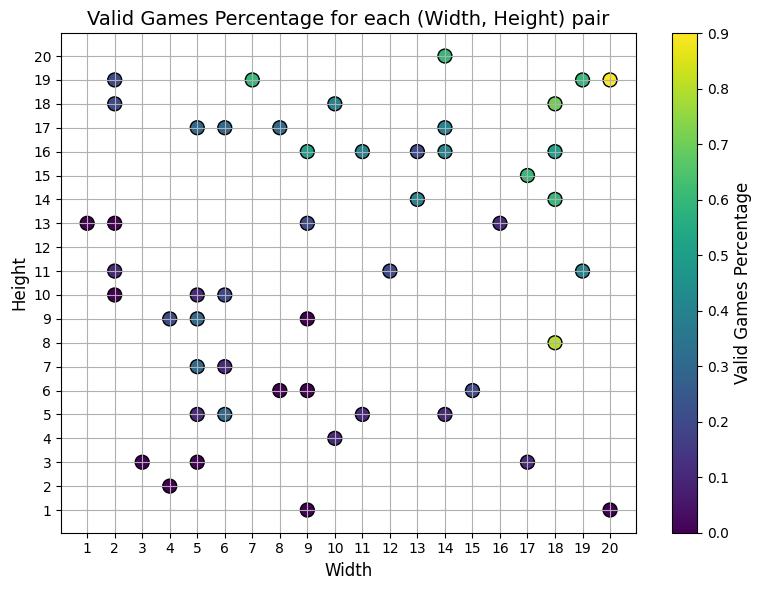

In [12]:
analyze_metric(results, lambda r: r.valid_games_percentage, 'Valid Games Percentage')

Mejores 5 de Unique Games Percentage:
Box(width=20, height=19) - 0.9
Box(width=18, height=8) - 0.8
Box(width=18, height=18) - 0.7
Box(width=7, height=19) - 0.6
Box(width=14, height=20) - 0.6
Peores 5 de Unique Games Percentage:
Box(width=3, height=3) - 0.0
Box(width=9, height=6) - 0.0
Box(width=8, height=6) - 0.0
Box(width=9, height=9) - 0.0
Box(width=2, height=13) - 0.0


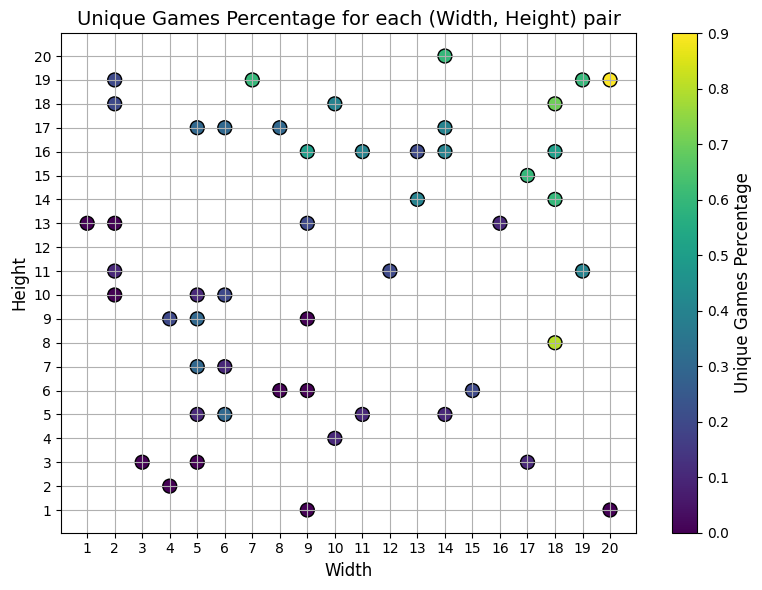

In [13]:
analyze_metric(results, lambda r: r.unique_games_percentage, 'Unique Games Percentage')

Mejores 5 de New Games Percentage:
Box(width=20, height=19) - 0.9
Box(width=18, height=8) - 0.8
Box(width=18, height=18) - 0.7
Box(width=7, height=19) - 0.6
Box(width=14, height=20) - 0.6
Peores 5 de New Games Percentage:
Box(width=3, height=3) - 0.0
Box(width=9, height=6) - 0.0
Box(width=8, height=6) - 0.0
Box(width=9, height=9) - 0.0
Box(width=2, height=13) - 0.0


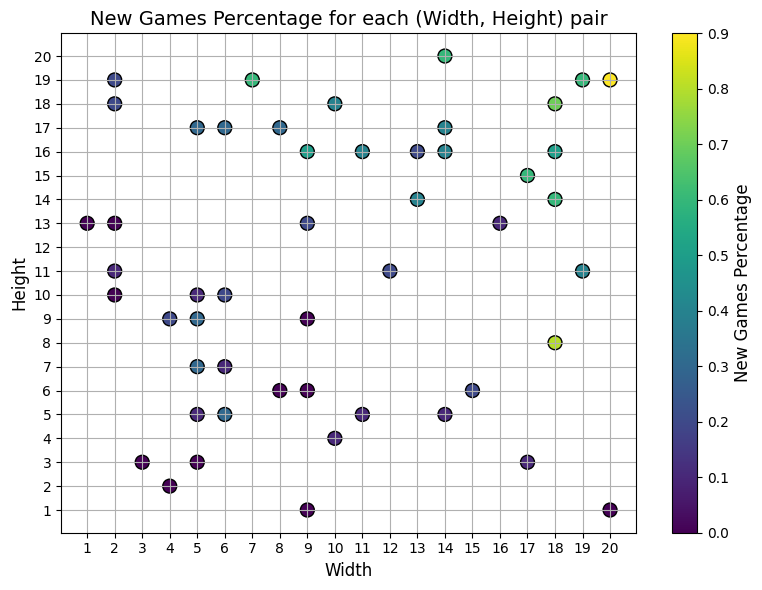

In [14]:
analyze_metric(results, lambda r: r.new_games_percentage, 'New Games Percentage')

Mejores 5 de Coverage Average:
Box(width=5, height=5) - 0.8
Box(width=10, height=4) - 0.75
Box(width=5, height=7) - 0.6285714285714286
Box(width=6, height=10) - 0.6000000000000001
Box(width=2, height=18) - 0.5416666666666667
Peores 5 de Coverage Average:
Box(width=3, height=3) - 0
Box(width=9, height=6) - 0
Box(width=8, height=6) - 0
Box(width=9, height=9) - 0
Box(width=2, height=13) - 0


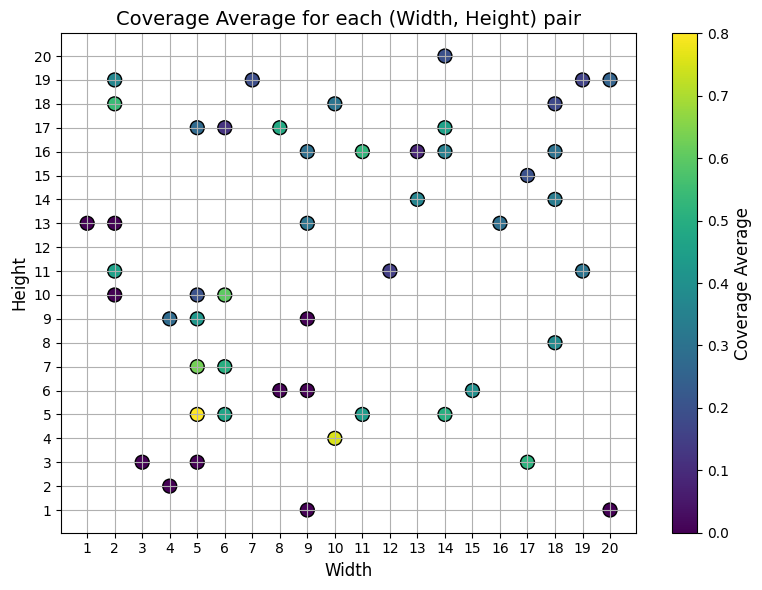

In [15]:
analyze_metric(results, lambda r: r.coverage_average, 'Coverage Average')

Mejores 5 de Box Count Average:
Box(width=11, height=16) - 2.5
Box(width=20, height=19) - 2.3333333333333335
Box(width=18, height=18) - 2.2857142857142856
Box(width=18, height=16) - 2.2
Box(width=8, height=17) - 2.0
Peores 5 de Box Count Average:
Box(width=3, height=3) - 0
Box(width=9, height=6) - 0
Box(width=8, height=6) - 0
Box(width=9, height=9) - 0
Box(width=2, height=13) - 0


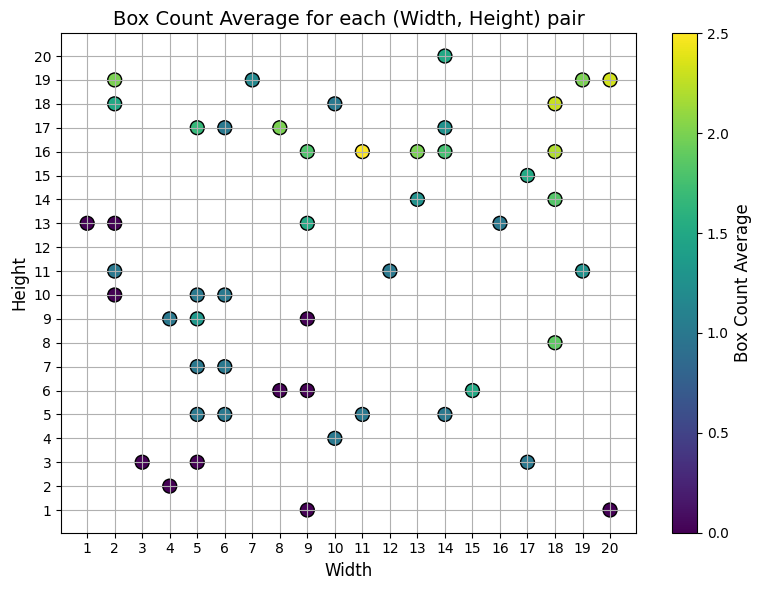

In [16]:
analyze_metric(results, lambda r: r.box_count_average, 'Box Count Average')

In [17]:
# Promedio total de todas las métricas en todas las configuraciones

valid_games_percentage =0
new_games_percentage = 0
unique_games_percentage = 0
coverage_average = 0
box_count_averags = 0

for result in results:
    valid_games_percentage += result.valid_games_percentage
    new_games_percentage += result.new_games_percentage
    unique_games_percentage += result.unique_games_percentage
    coverage_average += result.coverage_average
    box_count_averags += result.box_count_average

valid_games_percentage /= len(results)
new_games_percentage /= len(results)
unique_games_percentage /= len(results)
coverage_average /= len(results)
box_count_averags /= len(results)

print(f"Valid Games Percentage: {valid_games_percentage}")
print(f"New Games Percentage: {new_games_percentage}")
print(f"Unique Games Percentage: {unique_games_percentage}")
print(f"Coverage Average: {coverage_average}")
print(f"Box Count Average: {box_count_averags}")

Valid Games Percentage: 0.262
New Games Percentage: 0.262
Unique Games Percentage: 0.262
Coverage Average: 0.28616857235415266
Box Count Average: 1.1198809523809523
